Notebook to test kernel herding (solving the kernel moment matching sequentially) with a GAN generator.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

In [2]:
import kbrgan
import kbrgan.kernel as kernel
import kbrgan.glo as glo
import kbrgan.main as main
import kbrgan.plot as plot
import kbrgan.embed as embed
import kbrgan.util as util

import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
import scipy.stats as stats
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [3]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
use_cuda = True and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor if use_cuda else torch.FloatTensor)

## Feature extractor for MNIST

In [7]:
model_path = glo.share_path('prob_models/mnist_cnn/mnist_cnn_ep40_s1.pt')
# load the model
import kbrgan.mnist.classify as mnist_classify
from kbrgan.mnist.classify import MnistClassifier

# load option depends on whether GPU is used
load_options = {} if use_cuda else {'map_location': lambda storage, loc: storage} 

classifier = mnist_classify.MnistClassifier.load(model_path, **load_options)
classifier = classifier.eval()
classifier = classifier.to(device)
# classifier = classifier.cuda()

def extractor(imgs):
    """
    Feature extractor
    """
#     return classifier.features(imgs)
    self = classifier
    x = imgs
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2(x), 2))

#     x = x.view(-1, 10*12*12)
    x = x.view(-1, 320)
#     x = x.view(-1)
#     x = F.relu(self.fc1(x))
    return x


/usr/local/lib/python3.5/dist-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.dropout.Dropout2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.5/dist-packages/torch/serialization.py:434: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torc

In [9]:
# load MNIST data
mnist_folder = glo.data_file('mnist')
mnist_dataset = torchvision.datasets.MNIST(mnist_folder, download=True,train=False, 
                        transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
print(mnist_dataset)

Processing...
Done!
Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: /notebooks/psangkloy3/kbrgan_temp/data/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None


In [18]:
x.shape

torch.Size([1, 1, 28, 28])

features:  tensor([[-17.8923, -13.8913, -15.3083, -11.3180,  -3.6272,  -9.1909, -17.4032,
          -8.8685,  -5.9886,  -0.0298]], grad_fn=<LogSoftmaxBackward>)


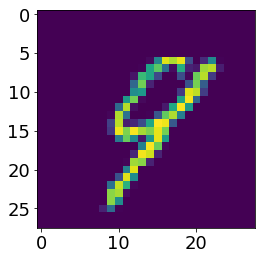

In [10]:
xy = mnist_dataset[92]
x = xy[0]
x = x.unsqueeze(0)
x = x.to(device)

# plot
xnp = np.transpose(xy[0].numpy(), (1, 2, 0))
xnp = xnp.squeeze()
plt.imshow(xnp)
print('features: ', classifier(x))

## A generator for MNIST

In [15]:
glo.share_path('prob_models/mnist_dcgan/mnist_dcgan_ep{}_bs{}.pt'.format(40, 64))

'/notebooks/psangkloy3/gdrive/condgan_share/prob_models/mnist_dcgan/mnist_dcgan_ep40_bs64.pt'

In [24]:
import kbrgan.mnist.dcgan as mnist_dcgan
import kbrgan.mnist.util as mnist_util

gan_fname = 'mnist_dcgan_ep{}_bs{}.pt'.format(40, 64)
gan_fpath = glo.share_path('prob_models/mnist_dcgan/mnist_dcgan_ep{}_bs{}.pt'.format(40, 64))#glo.prob_model_folder('mnist_dcgan', gan_fname)

# load a model
g = mnist_dcgan.Generator()#.load(gan_fpath, **load_options)
#g = g.to(device)

latent_dim = 100
f_noise = lambda n: torch.randn(n, latent_dim).float()

In [28]:
torch.load(gan_fpath)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=6272, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Upsample(scale_factor=2, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [33]:
g.load_state_dict(torch.load(gan_fpath, **load_options).state_dict(),strict=False)

## Optimize points jointly to minimize the moment matching loss

With a GAN generator. Optimize in the latent space.

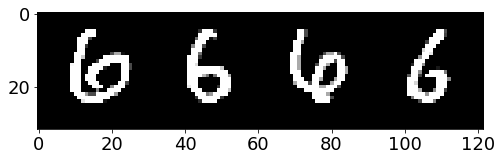

In [34]:
# label_counts = [(1, 3), (9, 3)]
# label_counts = [(6, 2), (8, 2)]
label_counts = [(6, 4)]
# label_counts = [(1,1), (2,1), (3,1), (4,1)]
# label_counts = [(i, 5) for i in range(10)]
# label_counts = [(0, 6), (5, 3)]
X = mnist_util.pt_sample_by_labels(mnist_dataset, label_counts)
X = X.to(device)
n = X.shape[0]

# A vector of weights for all the points in X
weights = torch.ones(n)/float(n)
weights = weights.to(device)
plot.show_torch_imgs(X)

In [37]:
# kernel on the extracted features
# k = kernel.PTKGauss(sigma2=50.0)
# k = kernel.PTKPoly(c=1e-1, d=2)
# k = kernel.PTKIMQ(c=1e+1, b=-0.5)
# k = kernel.PTKIMQ()
k = kernel.PTKLinear()

# kernel on the latent noise vectors
# k = kernel.PTKFuncCompose(kgauss, classifier)

# pre-extract the features of X. Fixed throughout the optimization
with torch.no_grad():
    FX = extractor(X)

In [39]:
X.shape

torch.Size([4, 1, 28, 28])

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


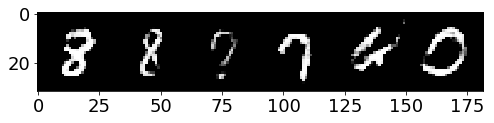

In [36]:
# initial points in the latent space
# n_sample = 2*2**3
# n_sample = 2*8
n_sample = 6
# noise vectors
Z = f_noise(n_sample)
Z = Z.to(device)

Z.requires_grad = True
Y0 = g(Z)

# plot the initial points in the image space
plot.show_torch_imgs(Y0.detach(), nrow=8)

Kernel herding (sequentially solving the kernel moment matching problem) with a generator

In [ ]:
# def kernel_generator_herding(X, weights, g, extractor, 
#                              k, Z0, fn_make_optimizer=None, n_iter=200, ):
"""
X: Pytorch tensor containing samples in the target mean embedding
weights: Pytorch vector containing weights for the samples in X
g: an instance of kbrgan.gen.PTNoiseTransformer representing a generator
extractor: a feature extractor
k: a kernel. An instance of PTKernel. This is used on top of the outputs from the extractor.
Z0: Pytorch tensor containing initial noise vectors to be optimized further.
    Z0[i, :] is point i. Each point is used in order.
fn_make_optimizer: a function: params -> a torch.optim.XXX optimizer. 
    A function that constructs an optimizer from a list of parameters.
n_iter: number of iterations for optimizing each y_i 

Return (Y, Y0), 
    Y: a Pytorch tensor of size n_sample x dim. Optimization result
    Y0: a Pytorch tensor of size n_sample x dim. Initial points picked
"""
Z0 = Z
n_iter = 200

In [ ]:
if n_sample <= 0:
    raise ValueError('n_sample must be > 0. Was {}'.format(n_sample))
# if fn_make_optimizer is None:
fn_make_optimizer = lambda params: torch.optim.Adam(params, lr=5e-2)

g = g.eval()
n = X.shape[0]
# a stack of all initial points
Y0 = []
# first iteration. Initialize.
z1 = Z0[[0]].detach().clone()
z1.requires_grad = True
y1 = g(z1)
Y0.append(y1.detach().clone())

# pre-extract features of X
with torch.no_grad():
    FX = extractor(X)

Losses = np.zeros((n_sample, n_iter))
# mean_KFX = torch.mean(k.eval(FX, FX))

# optimization for the first point
optimizer1 = fn_make_optimizer([z1])
reg = 1e-3
for it in range(n_iter):
    y1 = g(z1)
    fea1 = extractor(y1)
    z1_reg = reg*torch.sum(z1**2)
    loss1 = -2.0*k.eval(fea1, FX).mv(weights) + k.eval(fea1, fea1).reshape(-1) + z1_reg
    
    Losses[0, it] = loss1.item()
    # optimize z1
    optimizer1.zero_grad()

    # compute the gradients
    loss1.backward(retain_graph=True)
    # updates
    optimizer1.step()

# tensor to store the optimized points
Y = torch.cat([y1], dim=0)
# extracted features of points until iteration t-1
FY = torch.cat([fea1], dim=0)

# optimized Z
Z = torch.cat([z1], dim=0)
for t in range(2, n_sample+1):
    zt = Z0[[t-1]].detach().clone()
    zt.requires_grad = True
    yt = g(zt)
    Y0.append(yt.clone())

    optimizert = fn_make_optimizer([zt])  
    # optimization loop
    for it in range(n_iter):
        yt = g(zt)
        feat = extractor(yt)
        zt_reg = reg*torch.sum(zt**2)
        # optimize the rest of y2, ...y_{n_sample}
        losst =  - (2.0/t)*k.eval(feat, FX).mv(weights) \
            + (2.0/t**2)*torch.sum(k.eval(FY, feat)) + (1.0/t**2)*k.eval(feat, feat).reshape(-1) \
            + zt_reg

        Losses[t-1, it] = losst.item()
#             print(losst.item())
        # optimize zt
        optimizert.zero_grad()
        losst.backward(retain_graph=True)
        optimizert.step()

    # Now we have yt. Add it to the current set Y
    Y = torch.cat([Y, yt], dim=0)
    FY = torch.cat([FY, feat], dim=0)
    Z = torch.cat([Z, zt], dim=0)

assert Y.shape[0] == n_sample
assert FY.shape[0] == n_sample
Y0 = torch.cat(Y0, 0)
#     return Y, Y0
            
    

In [ ]:
# # optimization
# n_iter = 1000
# losses = []
# sample_interval = 200
# # avgpool = torch.nn.AvgPool2d(5, stride=1, padding=0)

# mean_KFX = torch.mean(k.eval(FX, FX))
# for t in range(n_iter):
#     # need to resize since Mnist uses 28x28. The generator generates 32x32
#     gens = g(Z)
# #     resized = torch.stack([resize_gen_img(I) for I in gens], 0)
# #     resized = avgpool(gens)
# #     plot.show_torch_imgs(resized)
#     F_gz = extractor(gens)
#     KF_gz = k.eval(F_gz, F_gz)
# #     print(KF_gz)
    
#     # encourage the latent noise vectors to concentrate around 0
#     Z_reg = 1e-6*torch.mean(torch.sum(Z**2, 1))
# #     Z_reg = -torch.mean(torch.log(4.0**2-Z**2))
#     loss = torch.mean(KF_gz)  - 2.0*torch.mean(k.eval(F_gz, FX).mv(weights)) + mean_KFX  + Z_reg
#     losses.append(loss.item())
    
#     optimizer.zero_grad()
    
#     # compute the gradients
#     loss.backward(retain_graph=True)
#     # updates
#     optimizer.step()
    
#     #--------- plots the generated images ----
#     if t%sample_interval==0:
#         with torch.no_grad():
#             gen = g(Z.detach().clone())
# #             gen = Z.detach().clone()
# #             gen = Z.grad.detach().clone()
#             plot.show_torch_imgs(gen)
#             plt.show()
    

In [ ]:
# kernel_generator_herding(X, weights, g, extractor, 
#                              k, Z, fn_make_optimizer=None, n_iter=200, )

In [ ]:
plt.plot(Losses.T)
plt.xlabel('Optimization iteration')
plt.ylabel('Herding loss')

In [ ]:
# input points
plot.show_torch_imgs(X)
plt.title('Input')

plot.show_torch_imgs(Y0.detach(), nrow=8)
plt.title('Initialized')

gen = Y.detach().cpu()
plot.show_torch_imgs(gen)
plt.title('Output')

In [ ]:
plt.imshow(Z.cpu().detach().numpy())
plt.colorbar()